In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
from pyspark.sql import functions as F, Window
from manga_recsys.spark import get_spark

spark = get_spark()

In [3]:
from IPython.display import display
from manga_recsys.models.manga import get_manga_tags

manga_info = spark.read.parquet(
    "../data/processed/2022-12-17-metadata-listing/manga_info.parquet"
)

manga_tags = get_manga_tags(manga_info)
manga_tags.show(5)

+--------------------+--------------------+
|                  id|                tags|
+--------------------+--------------------+
|0001183c-2089-48e...|[Psychological, D...|
|00016bf9-455f-44e...|[Oneshot, Sci-Fi,...|
|000245bf-670e-49c...|[Comedy, Video Ga...|
|00034238-6f5d-4f9...|[Oneshot, Boys' L...|
|0003d7e8-31da-463...|[Oneshot, Romance...|
+--------------------+--------------------+
only showing top 5 rows



In [4]:
from manga_recsys.models.manga import generate_manga_tags_tfidf_lsi

# https://radimrehurek.com/gensim/models/lsimodel.html
manga_tags_lsi, (_, lsi_model) = generate_manga_tags_tfidf_lsi(
    manga_info, return_model=True
)
display(manga_tags_lsi.head())
display(lsi_model.show_topics(10, 3))

,id,tags,lsi
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]","[0.20599135756492615, 0.16202980279922485, -0...."
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]","[0.12215349823236465, -0.06712178140878677, -0..."
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]","[0.13383647799491882, 0.07919834554195404, 0.0..."
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]","[0.6099280714988708, -0.6543454527854919, 0.19..."
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ...","[0.5612652897834778, -0.23717640340328217, -0...."


[(0, '0.359*"Oneshot" + 0.355*"Romance" + 0.355*"Doujinshi"'),
 (1, '-0.685*"Doujinshi" + -0.435*"Oneshot" + 0.229*"Romance"'),
 (2, '0.540*"Boys\' Love" + -0.317*"Fantasy" + -0.279*"Full Color"'),
 (3, '0.687*"Boys\' Love" + -0.384*"School Life" + -0.249*"Slice of Life"'),
 (4, '-0.421*"Web Comic" + -0.393*"Full Color" + -0.372*"Long Strip"'),
 (5, '-0.764*"Oneshot" + 0.530*"Doujinshi" + 0.221*"Girls\' Love"'),
 (6, '0.783*"Slice of Life" + -0.537*"School Life" + -0.171*"Romance"'),
 (7, '0.771*"Girls\' Love" + 0.320*"Drama" + -0.296*"Comedy"'),
 (8, '0.484*"Drama" + -0.431*"Girls\' Love" + 0.278*"Romance"'),
 (9, '0.631*"Romance" + -0.462*"School Life" + -0.221*"Supernatural"')]

In [5]:
lsi_model.projection.u.shape

(76, 16)

In [6]:
from manga_recsys.models.manga import generate_recommendations

manga_rec = generate_recommendations(manga_tags_lsi, "id", "lsi")
manga_rec.head()

f:\code\mangadex\.venv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


,id,tags,lsi,recommendations,distances
0,0001183c-2089-48e9-96b7-d48db5f1a611,"[Psychological, Drama, Supernatural]","[0.20599135756492615, 0.16202980279922485, -0....","[07b5841e-1076-4b73-a5c4-5a1abb532bdd, f0acfa3...","[1.1920927089903444e-07, 1.1920927089903444e-0..."
1,00016bf9-455f-44e5-ab27-55ac7f69aad2,"[Oneshot, Sci-Fi, Post-Apocalyptic, Tragedy]","[0.12215349823236465, -0.06712178140878677, -0...","[00016bf9-455f-44e5-ab27-55ac7f69aad2, 1b815f8...","[0.0, 0.0, 0.0023181220571736327, 0.0023181220..."
2,000245bf-670e-49c5-af47-1d674a43525c,"[Comedy, Video Games, Slice of Life, Music]","[0.13383647799491882, 0.07919834554195404, 0.0...","[000245bf-670e-49c5-af47-1d674a43525c, 686426b...","[0.0, 0.0, 0.000993217946743341, 0.00099321794..."
3,00034238-6f5d-4f98-a51c-69afb21d920f,"[Oneshot, Boys' Love, Doujinshi]","[0.6099280714988708, -0.6543454527854919, 0.19...","[c1af5867-85b9-459a-8f83-6185f79bee17, a523490...","[1.1920927089903444e-07, 1.1920927089903444e-0..."
4,0003d7e8-31da-463b-97e9-e87045f8f5ee,"[Oneshot, Romance, Doujinshi, Drama, Slice of ...","[0.5612652897834778, -0.23717640340328217, -0....","[e1676745-3733-40a2-86a6-a1b3661b2900, 0003d7e...","[0.0, 0.0, 0.01781135782629406, 0.037025564746..."


In [7]:
from manga_recsys.models.manga import recs_with_secondary_tag, plot_recommendation_2d

primary_tag = "Isekai"
manga_rec_tag = recs_with_secondary_tag(
    spark, manga_rec, manga_tags, primary_tag, verbose=True
)

f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Action|  575|
|   Fantasy|  391|
|Adaptation|  385|
|    Comedy|  326|
|     Other|  299|
|     Drama|  136|
+----------+-----+

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|                  id|                tags|                 lsi|     recommendations|           distances|       tag|count|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|000b6cbb-f99a-458...|[Reincarnation, S...|[0.20849452912807...|[000b6cbb-f99a-45...|[0.0, 0.033978061...|   Fantasy|   10|
|0014776a-d47f-461...|[Reincarnation, M...|[0.25904881954193...|[0014776a-d47f-46...|[-1.1920930509390...|    Action|   10|
|002871dd-5d07-420...|[Monsters, Action...|[0.15568995475769...|[002871dd-5d07-42...|[-1.1920930509390...|    Action|   10|
|0030db10-93a6-4f6...|[Reincarnation, R...|[0.14169360697269...|[

f:\code\mangadex\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


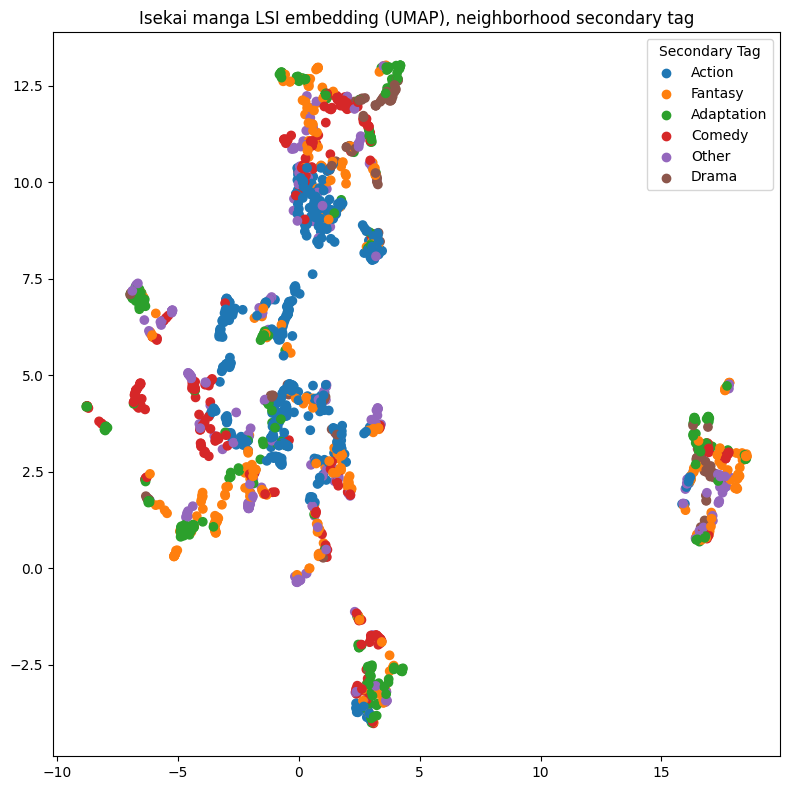

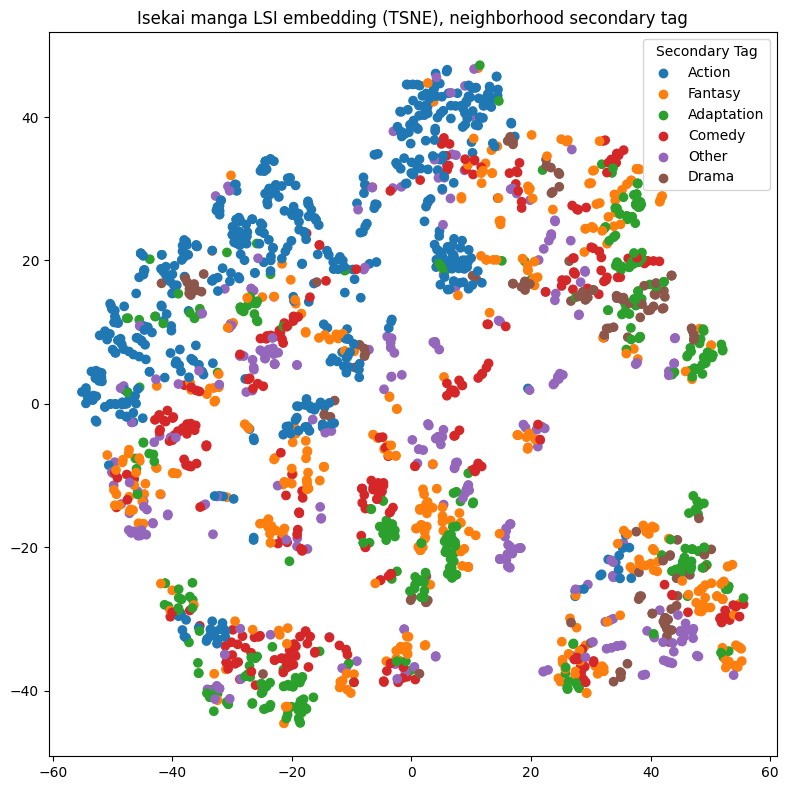

In [8]:
# plot using umap and t-sne

import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

for reducer in [umap.UMAP(n_components=2, metric="cosine"), TSNE(n_components=2)]:
    plot_recommendation_2d(
        manga_rec_tag,
        "lsi",
        reducer,
        title=f"{primary_tag} manga LSI embedding ({reducer.__class__.__name__}), neighborhood secondary tag",
    )
    plt.show()

f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|    Comedy| 7042|
|     Other| 6355|
|Boys' Love| 4908|
|     Drama| 4142|
|    Action| 1689|
|   Fantasy| 1118|
|      null|  573|
+----------+-----+

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|                  id|                tags|                 lsi|     recommendations|           distances|       tag|count|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|07c7ac62-c738-480...|[Demons, Romance,...|[0.25048202276229...|[07c7ac62-c738-48...|[0.0, 0.042698726...|   Fantasy|   10|
|07d69599-62a9-446...|[Historical, Long...|[0.34566563367843...|[07d69599-62a9-44...|[0.0, 0.004891077...|Boys' Love|   10|
|07d858d0-1537-487...|[Thriller, Histor...|[0.19338709115982...|[07d858d0-1537-48...|[0.0, 0.010478285...|    Action|   10|
|0fae2dd9-96de-4fc...|[Oneshot, Romance...|[0.

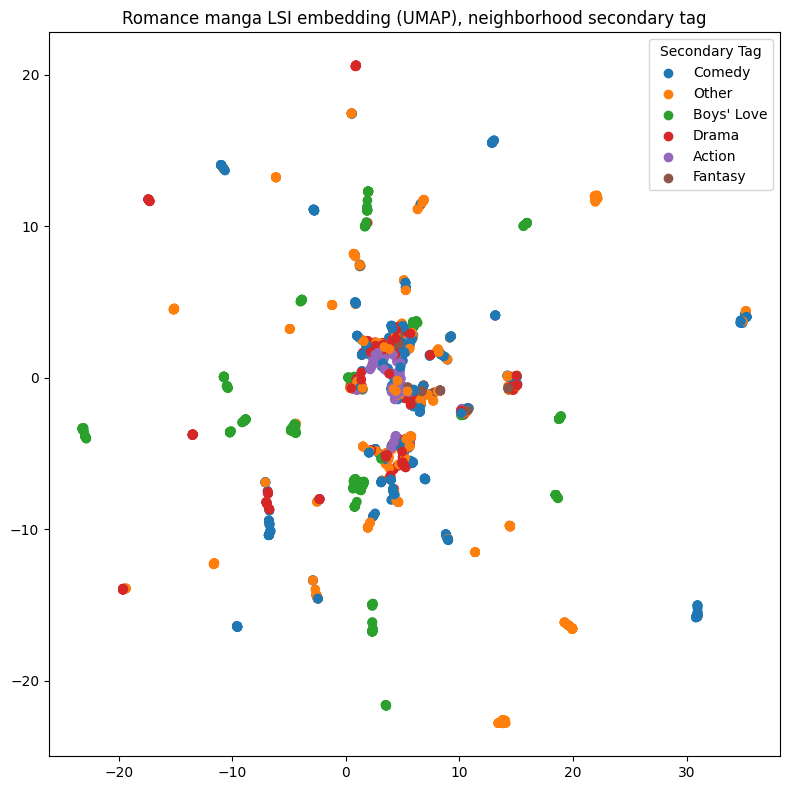

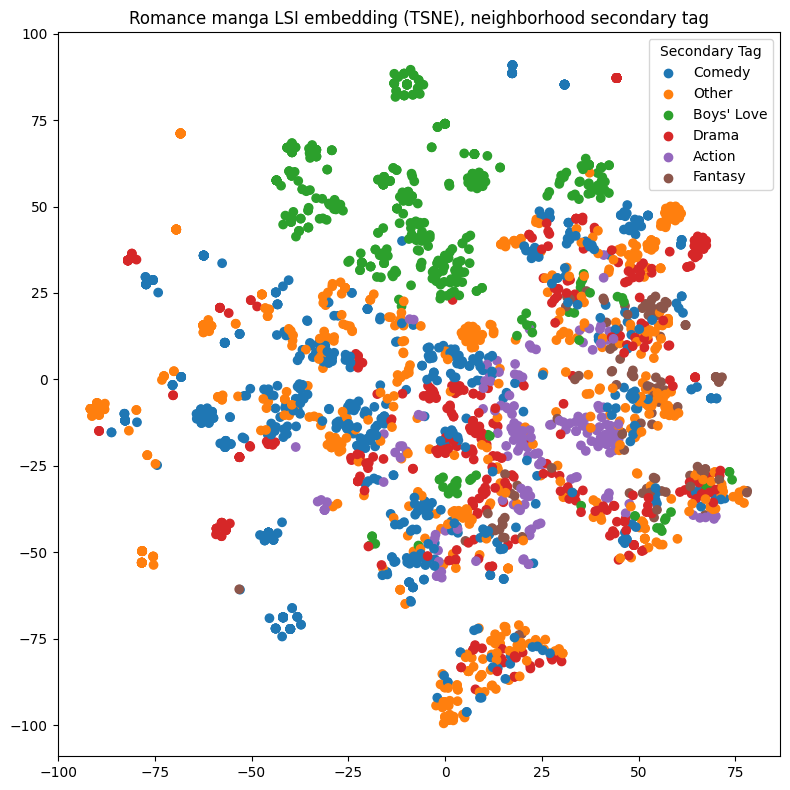

In [10]:
primary_tag = "Romance"
manga_rec_tag = recs_with_secondary_tag(spark, manga_rec, manga_tags, primary_tag)

for reducer in [umap.UMAP(n_components=2, metric="cosine"), TSNE(n_components=2)]:
    plot_recommendation_2d(
        manga_rec_tag,
        "lsi",
        reducer,
        title=f"{primary_tag} manga LSI embedding ({reducer.__class__.__name__}), neighborhood secondary tag",
        sample=2500,
    )
    plt.show()

f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]
f:\code\mangadex\.venv\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


+----------+-----+
|       tag|count|
+----------+-----+
|     Other| 3924|
|    Action| 3791|
|    Comedy| 1901|
|     Drama| 1228|
|Boys' Love|  861|
|Full Color|  695|
|      null|   70|
+----------+-----+

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|                  id|                tags|                 lsi|     recommendations|           distances|       tag|count|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-----+
|00148825-e802-456...|[Action, Romance,...|[0.35630553960800...|[00148825-e802-45...|[-1.1920930509390...|     Other|   10|
|085cd1c3-8a7b-4bf...|[Comedy, Adventur...|[0.27194741368293...|[8cc5cc11-558f-4f...|[0.0, 0.0, 0.0, 0...|    Comedy|   10|
|1064e8a5-0de9-401...|[Historical, Long...|[0.31806114315986...|[29ae7262-b282-42...|[-5.9604650770594...|     Drama|   10|
|188558f7-ecb6-479...|[Long Strip, Come...|[0.

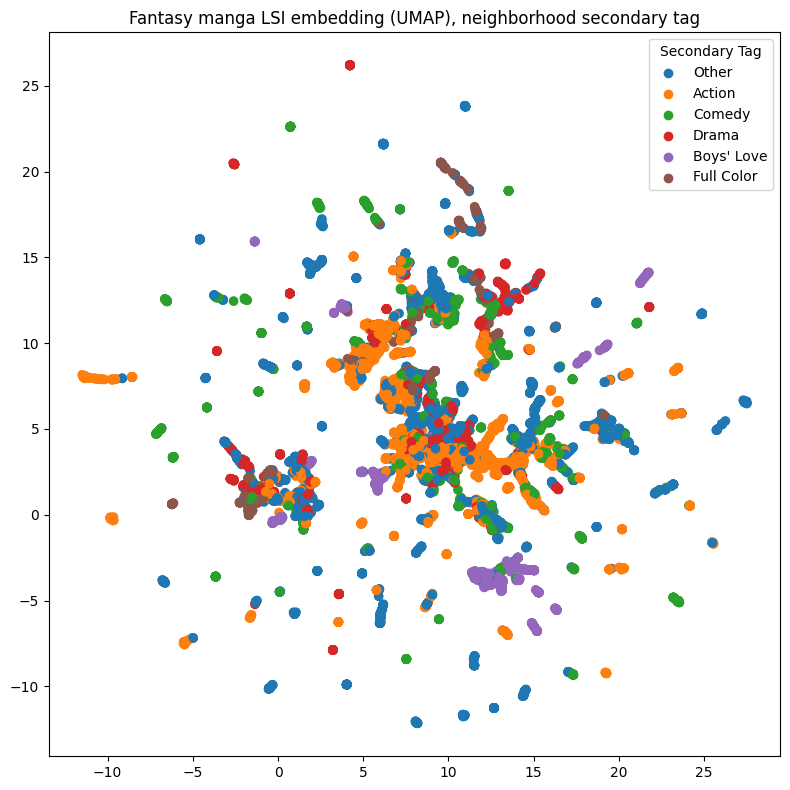

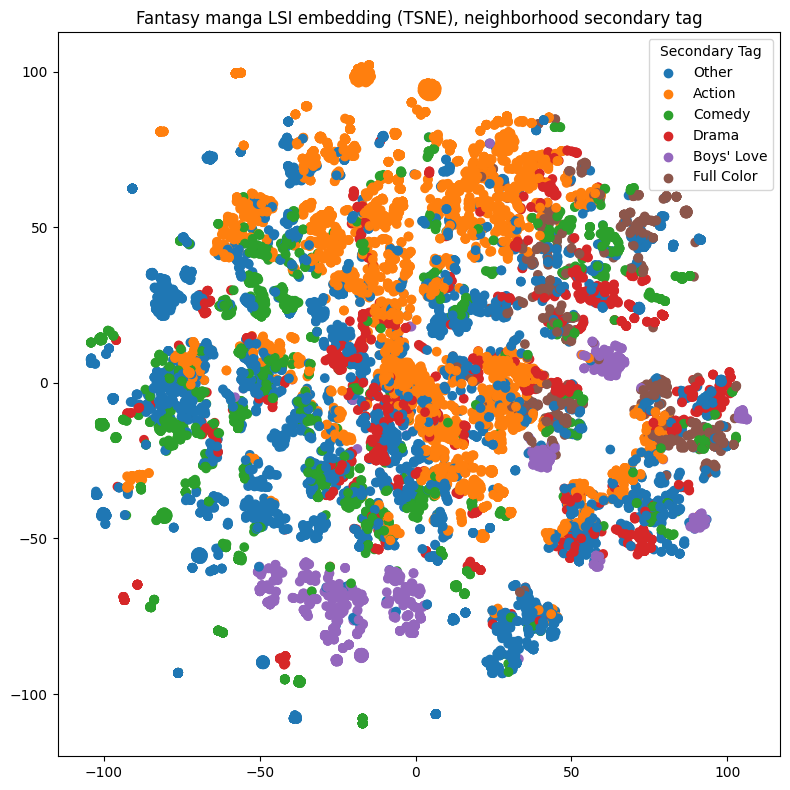

In [11]:
primary_tag = "Fantasy"
manga_rec_tag = recs_with_secondary_tag(spark, manga_rec, manga_tags, primary_tag)

for reducer in [umap.UMAP(n_components=2, metric="cosine"), TSNE(n_components=2)]:
    plot_recommendation_2d(
        manga_rec_tag,
        "lsi",
        reducer,
        title=f"{primary_tag} manga LSI embedding ({reducer.__class__.__name__}), neighborhood secondary tag",
    )
    plt.show()